In [ ]:
# ....... look into filtered merged Cui et al data ....... #

In [39]:
library(SingleCellExperiment)
library(MetaNeighbor)
library(MetaMarkers)
library(scater)
library(dplyr)

In [40]:
cuimat = read.delim('~/heart/GSE106118_UMI_count_merge.txt', sep = '\t')
cuicls = read.delim('~/heart/cui_cluster_anno.csv', sep = ',')
# cuibarcodes = read.delim('~/heart/GSE106118_barcode_information.txt', sep = '\t')

In [160]:
# scRNA-seq - wow!
mean(colSums(cuimat, na.rm = T))
median(colSums(cuimat, na.rm = T))
dim(cuimat)

[1] 94023.81

[1] 66476.5

[1] 24153  4948

In [42]:
ginfo = read.delim('/data/CoCoCoNet/geneInfo/human_info.csv', sep = ',')
minfo = read.delim('/data/CoCoCoNet/geneInfo/mouse_info.csv', sep = ',')

In [43]:
om = read.delim('/data/CoCoCoNet/orthologMaps/human_mouse_orthoNM.csv', sep = ',')
om[1:3,]

human           mouse              human_OrthoID mouse_OrthoID 
1 ENSG00000198712 ENSMUSG00000064354 9606_0:00000a 10090_0:000000
2 ENSG00000198763 ENSMUSG00000064345 9606_0:000002 10090_0:000001
3 ENSG00000198727 ENSMUSG00000064370 9606_0:000006 10090_0:000002

In [44]:
genes = unlist(cuimat[,1])
cuimat <- as.matrix(cuimat[,-1])
rownames(cuimat) = genes

cuimat[1:2,1:3]

HE5W_1_LA.1 HE5W_1_LA.2 HE5W_1_LA.3
A1BG     0           0           0          
A1BG-AS1 0           0           0

In [45]:
# subset to 3842 cells with anno
mat2 = cuimat[,which(!is.na(match(colnames(cuimat), cuicls$Cell.Name)))]

# SCE object
mat2 = SingleCellExperiment(mat2)
colData(mat2)$Cluster = cuicls$Cluster[match(colnames(mat2), cuicls$Cell.Name)]
colData(mat2)$Dataset = 'Cui'
rownames(colData(mat2)) = colnames(mat2)

rownames(mat2) <- ginfo$EnsemblID[match(rownames(mat2), ginfo$GeneSymbol)]
mat2 <- mat2[!is.na(rownames(mat2)),]
rowData(mat2)$Gene = rownames(mat2)
rowData(mat2)$Symbol = ginfo$GeneSymbol[match(rownames(mat2), ginfo$EnsemblID)]

assay(mat2, "cpm") = convert_to_cpm(assay(mat2))
assayNames(mat2) <- c('counts', 'cpm')

In [13]:
# 3842 of 4948 cells have cluster anno
table(cuicls$Cluster)


                  C1 (5W)                   C2 (CM) C3 (Fibroblast-like cell) 
                      257                      1492                       786 
                  C4 (EC)          C5 (Valvar cell)                   C6 (EP) 
                      445                       427                        46 
           C7 (Mast cell)           C8 (Macrophage)            C9 (B/T cells) 
                       27                       304                        58 

In [100]:
mat2

class: SingleCellExperiment 
dim: 20855 3842 
metadata(0):
assays(2): counts cpm
rownames(20855): ENSG00000121410 ENSG00000268895 ... ENSG00000074755
  ENSG00000036549
rowData names(2): Gene Symbol
colnames(3842): HE5W_1_LA.1 HE5W_1_LA.3 ... HE23W_2_RV.22 HE23W_2_RV.24
colData names(2): Cluster Dataset
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [101]:
start.time <- Sys.time()
hvg = variableGenes(mat2, exp_labels = mat2$Cluster)
# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

Time difference of 2.472189 secs

[1] 304

In [81]:
# load mouse devp data
library(Matrix)
# barcodes = read.delim('~/heart/mouse/GSM4644950_P1_1Sham_barcodes.tsv', sep = '\t', header = FALSE)
# features = read.delim('~/heart/mouse/GSM4644950_P1_1Sham_genes.tsv', sep = '\t', header = FALSE)
barcodes = read.delim('~/heart/mouse/GSM4644954_P8_1Sham_barcodes.tsv', sep = '\t', header = FALSE)
features = read.delim('~/heart/mouse/GSM4644954_P8_1Sham_genes.tsv', sep = '\t', header = FALSE)

In [82]:
# load timepoint by timepoint
# aa = readMM('~/heart/mouse/GSM4644950_P1_1Sham_matrix.mtx')
aa = readMM('~/heart/mouse/GSM4644954_P8_1Sham_matrix.mtx')
aa <- as(aa, "dgCMatrix")

In [83]:
str(aa)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:3211964] 7 62 118 162 188 189 207 227 292 304 ...
  ..@ p       : int [1:1962] 0 920 3294 5900 7156 8613 9818 10843 12713 14473 ...
  ..@ Dim     : int [1:2] 28692 1961
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : NULL
  ..@ x       : num [1:3211964] 1 1 1 1 3 1 1 3 1 2 ...
  ..@ factors : list()


In [84]:
counts <- sparseMatrix(dims = aa@Dim, i = as.numeric(aa@i), p = as.numeric(aa@p),
    x = as.numeric(aa@x), index1 = FALSE)
mat3 = SingleCellExperiment(counts, rowData = features, colData = barcodes)

In [85]:
# subset to orthologs with human
rownames(mat3) <- om$human[match(features[,1], om$mouse)]
mat3 <- mat3[!is.na(rownames(mat3)),]

In [86]:
# subset to common genes
cgenes = intersect(rownames(mat2), rownames(mat3))
mat2 <- mat2[cgenes,]
mat3 <- mat3[cgenes,]

In [87]:
rowData(mat3) <- rowData(mat2)
colnames(mat3) = unlist(barcodes)

In [88]:
# SCE object
colData(mat3) = NULL
colData(mat3)$Dataset = 'Mouse'
rownames(colData(mat3)) = colnames(mat3)

In [89]:
assay(mat3, "cpm") = convert_to_cpm(assay(mat3))
assayNames(mat3) <- c('counts', 'cpm')

In [90]:
mat3

class: SingleCellExperiment 
dim: 15161 1961 
metadata(0):
assays(2): counts cpm
rownames(15161): ENSG00000121410 ENSG00000148584 ... ENSG00000074755
  ENSG00000036549
rowData names(2): Gene Symbol
colnames(1961): AAACCTGAGAGTACCG-1 AAACCTGAGCCAACAG-1 ...
  TTTGTCATCAAACAAG-1 TTTGTCATCGTCCAGG-1
colData names(1): Dataset
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [91]:
# scRNA-seq - wow! --- 3385, 2299
mean(colSums(counts(mat3), na.rm = T))
median(colSums(counts(mat3), na.rm = T))
dim(mat3)

[1] 3292.453

[1] 2299

[1] 15161  1961

In [92]:
start.time <- Sys.time()
hvg = variableGenes(mat2, exp_labels = mat2$Cluster)
# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

Time difference of 1.431255 secs

[1] 153

In [75]:
source('gene_set_enrichment.R')
gse = gene_set_enrichment(hvg, 'human')
gse$description[gse$sig==TRUE][1:10]
head(gse)

[1] "mitotic cell cycle"                                 
 [2] "mitotic cell cycle process"                         
 [3] "cell division"                                      
 [4] "regulation of mitotic cell cycle"                   
 [5] "regulation of cell cycle process"                   
 [6] "chromosomal region"                                 
 [7] "regulation of cell cycle phase transition"          
 [8] "regulation of mitotic cell cycle phase transition"  
 [9] "regulation of cell cycle G2/M phase transition"     
[10] "regulation of G2/M transition of mitotic cell cycle"

GO_term    description                      N_sample N_univ
GO:0000278 GO:0000278 mitotic cell cycle               43       766   
GO:1903047 GO:1903047 mitotic cell cycle process       41       681   
GO:0051301 GO:0051301 cell division                    30       528   
GO:0007346 GO:0007346 regulation of mitotic cell cycle 35       809   
GO:0010564 GO:0010564 regulation of cell cycle process 35       899   
GO:0098687 GO:0098687 chromosomal region               24       393   
           pvals        adj_pvals    sig 
GO:0000278 1.324036e-28 9.226133e-25 TRUE
GO:1903047 2.052532e-28 9.226133e-25 TRUE
GO:0051301 4.770414e-20 1.429534e-16 TRUE
GO:0007346 1.576869e-19 3.544013e-16 TRUE
GO:0010564 4.367495e-18 7.852756e-15 TRUE
GO:0098687 7.225676e-17 1.082647e-13 TRUE

In [97]:
genes22 = hvg
data1 = mat2[genes22,]
data2 = mat3[genes22,]
# colData(data1) <- colData(data1)[c('Cluster', 'Dataset')]
# rowData(data1) <- rowData(data1)[c('Gene', 'Symbol')]

In [98]:
newmat = cbind(data1, data2)
dim(newmat)

[1]  153 5803

In [99]:
start.time <- Sys.time()

auroc1 = MetaNeighborUS(var_genes = genes22, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$Cluster, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = FALSE)

auroc2 = MetaNeighborUS(var_genes = genes22, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$Cluster, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = FALSE)


end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 0.1550114 secs

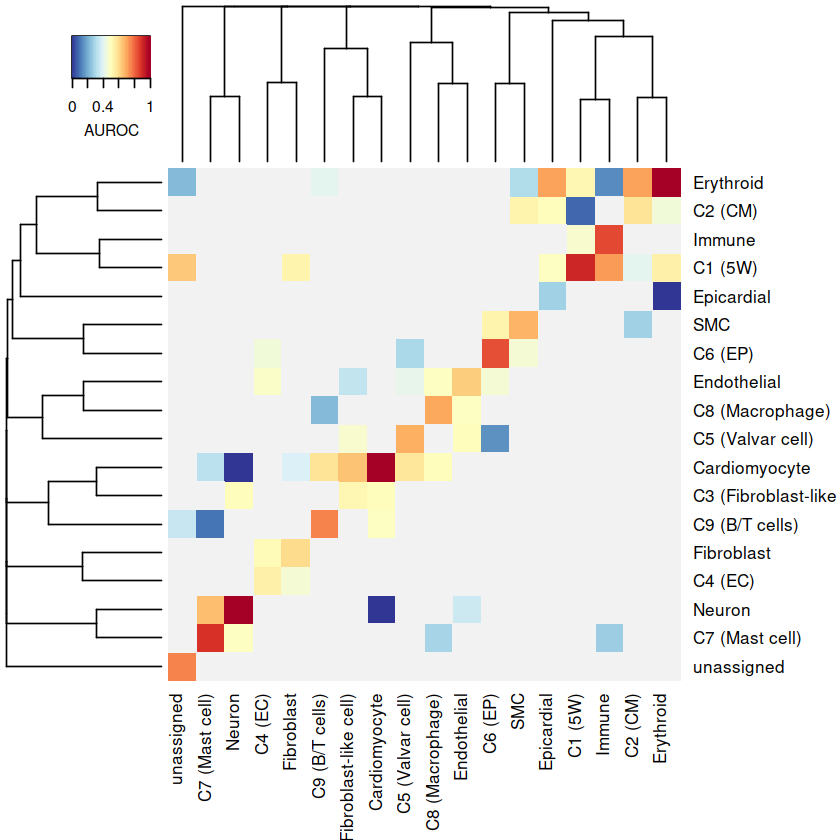

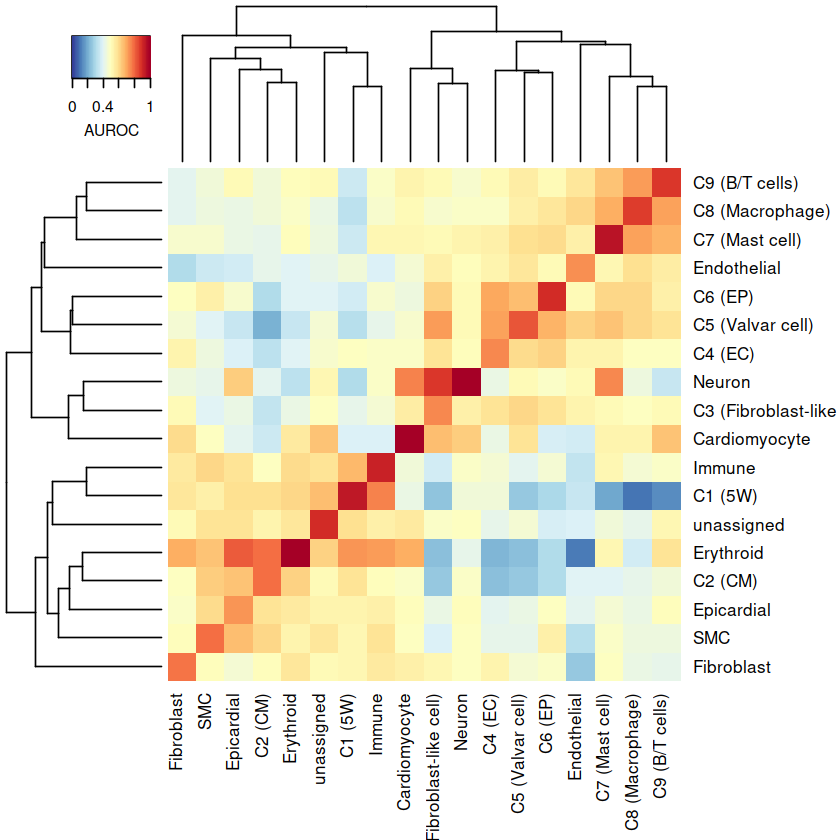

In [100]:
# png('mouse_P1_1vsbest.png', width = 10, height = 10, res = 300, units = 'in')
currmat = auroc1
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
# dev.off()

# png('mouse_P1_allvsall.png', width = 10, height = 10, res = 300, units = 'in')
currmat = auroc2
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
# dev.off()

In [ ]:
# also do cell type enrichment for marker gene sets in Amalia's data

In [65]:
markers = read.delim('~/heart/human_heart_dev_markers.csv', sep = ',')
markers[1:3,]

Gene   Celltype     
1 MYBPC3 Cardiomyocyte
2 RBM20  Cardiomyocyte
3 RYR2   Cardiomyocyte

In [66]:
# Cui et al 3.8k cells dataset
top_markers = data.frame(gene = ginfo$EnsemblID[match(markers[,1], ginfo$GeneSymbol)], cell_type = as.factor(markers[,2]), group = 'sim_SI')
ct_scores = score_cells(log1p(cpm(mat2)), top_markers)
ct_enrichment = compute_marker_enrichment(ct_scores)
ct_pred = assign_cells(ct_scores)
ct_pred$anno = mat2$Cluster

In [67]:
# verify in original Cui et al data
table(ct_pred$anno)
table(ct_pred$predicted[grep('C1', ct_pred$anno)])


                  C1 (5W)                   C2 (CM) C3 (Fibroblast-like cell) 
                      257                      1492                       786 
                  C4 (EC)          C5 (Valvar cell)                   C6 (EP) 
                      445                       427                        46 
           C7 (Mast cell)           C8 (Macrophage)            C9 (B/T cells) 
                       27                       304                        58 


Cardiomyocyte    Epicardial     Erythroid    Fibroblast 
          225            25             1             6 

In [93]:
# ........ now on Amalia's dataset ......... #
ct_scores = score_cells(log1p(cpm(mat3)), top_markers)
ct_enrichment = compute_marker_enrichment(ct_scores)
ct_pred = assign_cells(ct_scores)

In [94]:
table(ct_pred$predicted)


Cardiomyocyte   Endothelial    Epicardial     Erythroid    Fibroblast 
            3          1200           188             5           366 
       Immune        Neuron           SMC    unassigned 
           24             1           138            36 

In [95]:
head(ct_pred)
dim(ct_pred)
barcodes[1:5,]
dim(barcodes)

group  predicted   score    enrichment
AAACCTGAGAGTACCG-1 sim_SI Endothelial 2.154508 4.435355  
AAACCTGAGCCAACAG-1 sim_SI Endothelial 4.444953 3.405431  
AAACCTGCAAACCCAT-1 sim_SI Endothelial 4.015593 4.060709  
AAACCTGCAGACGCTC-1 sim_SI Endothelial 1.370575 7.995917  
AAACCTGGTGTGCCTG-1 sim_SI Endothelial 2.724899 5.479496  
AAACCTGTCAGCTGGC-1 sim_SI Endothelial 2.034342 5.576356

[1] 1961    4

[1] "AAACCTGAGAGTACCG-1" "AAACCTGAGCCAACAG-1" "AAACCTGCAAACCCAT-1"
[4] "AAACCTGCAGACGCTC-1" "AAACCTGGTGTGCCTG-1"

[1] 1961    1

In [96]:
mat3$Cluster <- ct_pred$predicted

In [153]:
table(ct_pred$predicted[which(ct_pred$anno=='Cardiomyocyte')])

< table of extent 0 >

In [154]:
outmat = ct_pred %>% group_by(anno, predicted) %>% summarize(sumAmount = length(predicted))
head(outmat)

`summarise()` has grouped output by 'anno'. You can override using the `.groups` argument.



anno             predicted     sumAmount
1 Cardiomyocytes-1 Cardiomyocyte  1       
2 Cardiomyocytes-1 Endothelial    4       
3 Cardiomyocytes-1 Epicardial    50       
4 Cardiomyocytes-1 Erythroid     72       
5 Cardiomyocytes-1 Fibroblast    10       
6 Cardiomyocytes-1 Immune         1

In [156]:
new2 = matrix(0, nrow = length(unique(ct_pred$anno)), ncol = 8)
colnames(new2) = unique(ct_pred$predicted)[1:8]
rownames(new2) = unique(ct_pred$anno) #paste0('cluster_', 1:20)

# map df to matrix
ids = cbind(match(unlist(outmat[,1]), rownames(new2)), match(unlist(outmat[,2]), colnames(new2)), outmat$sumAmount)
ids <- ids[which(!is.na(ids[,2])),]
for(ii in 1:dim(ids)[1])  {new2[ids[ii,1],ids[ii,2]] <- ids[ii,3]}

# get fraction of cell type
outmat2 = sweep(new2, 1, rowSums(new2), FUN = '/')

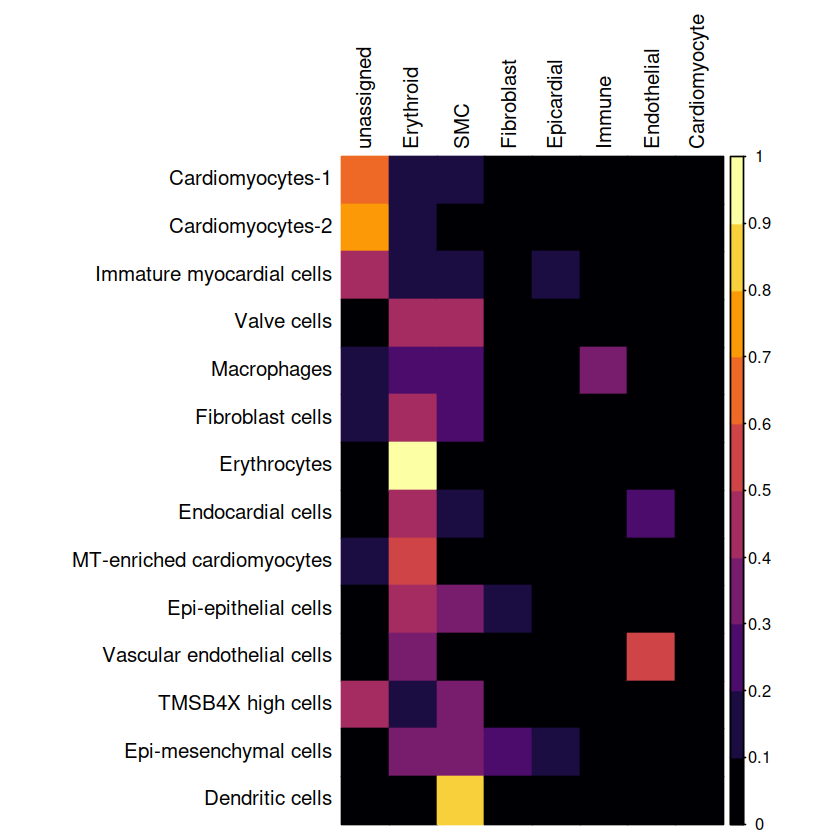

In [159]:
library(corrplot)
library(viridis)
my_palette = viridis::inferno(10)

# png(paste0('chick_D4_markerset_fraction.png'), width = 5, height = 5, res = 300, units = 'in')
# pdf('aa-bbs5-sc-5x5.pdf', width = 5, height = 5)
corrplot(outmat2, method = 'color', is.corr = F, col = my_palette, #col.lim = c(0,1),
         tl.col = 'black', na.label = ' ', na.label.col = 'white')
# dev.off()